# Glauber dynamics on asymmetric directed graphs

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, SparseArrays
using Random, Statistics
using Plots
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [92]:
include("../../telegram/notifications.jl");

In [219]:
T = 20
N = 100
k = 3
seed = 3
rng = MersenneTwister(seed)
gg = random_regular_graph(N, k; seed)
# gg = prufer_decode(rand(rng, 1:N, N-2))
# gg = path_graph(N)
A = adjacency_matrix(gg)
for e in edges(gg)
    i = src(e); j = dst(e)
    r = rand(rng)
    if r < 1/3
        A[i,j] = 0
    elseif 1/3 < r < 2/3
        A[j,i] = 0
    end
end
dropzeros!(A)
g = IndexedBiDiGraph(gg)
β = 2.0
J = 1.0
h = 0.0
w = [fill(PMJGlauberFactor([A[j,i] for j in inneighbors(g,i)], J, h, β), T+1) for i in vertices(g)]
# w = [fill(GenericGlauberFactor([A[j,i] for j in inneighbors(g,i)]*J, h, β), T+1) for i in vertices(g)]
m⁰ = 0.5
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
bp = mpbp(g, w, fill(2,N), T; ϕ=fill(ϕᵢ,N));

LoadError: MethodError: no method matching PMJGlauberFactor(::Vector{Any}, ::Float64, ::Float64, ::Float64)
[0mClosest candidates are:
[0m  PMJGlauberFactor([91m::Vector{Int64}[39m, ::T, ::T, ::T) where T<:Real at ~/MatrixProductBP/src/Models/glauber/glauber_bp.jl:64
[0m  PMJGlauberFactor([91m::Vector{Int64}[39m, ::T, ::T) where T<:Real at ~/MatrixProductBP/src/Models/glauber/glauber_bp.jl:59

In [182]:
# using GraphRecipes
# graphplot(SimpleDiGraph(A), curves=false, size=(600,600), nodeshape=:circle, names=1:N, 
#     nodecolor=:white, nodesize=0.2)

In [210]:
reset!(bp)
spin(x, i) = 3-2x
spin(x) = spin(x, 0)
cb = CB_BP(bp; f=spin);

In [ ]:
svd_trunc = TruncBondThresh(30, 1e-4)
iters, cb = iterate!(bp, maxiter=50; svd_trunc, cb, tol=1e-3, damp=0.0);

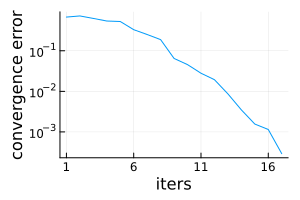

In [216]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [217]:
m_bp = means(spin, bp);

In [ ]:
sms = SoftMarginSampler(bp);

In [ ]:
sample!(sms, 10^4);

In [ ]:
b_mc = marginals(sms)
m_mc = means(spin, sms);

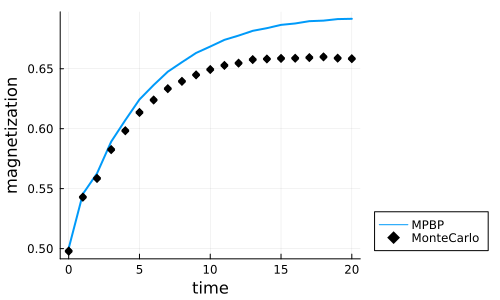

In [218]:
pl = plot(0:T, mean(m_bp), lw=2, xlabel="time", ylabel="magnetization",
    size=(500,300), label="MPBP", legend=:outerbottomright)
scatter!(pl, 0:T, mean(m_mc), c=:black, m=:diamond, label="MonteCarlo")
# plot!(pl, 0:T, mean(m_exact), ls=:dash, c=:red, label="Exact")

In [ ]:
@telegram "glauber asymm"